In [2]:
# --- Import packages ---
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import math

from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
import seaborn as sns

Delta Plot Year 2050

In [3]:
# --- Read data ---

# Read data into a DataFrame and filter year
report = pd.read_excel('gen.xlsx')
graph_data = pd.DataFrame(pd.pivot_table(data = report.loc[report.year == 2050], columns = 'tech', index = 'scenario', values = 'Generation (TWh)', aggfunc = 'sum', fill_value = 0))
graph_data.reset_index(inplace = True, drop = False)
x_scens = graph_data.scenario.tolist()

# Get tech colors and put them into a dictionary
tech_styles = pd.read_csv('tech_styles.csv')
tech_styles_dict = tech_styles.set_index(tech_styles.order)['color'].to_dict()


# --- Data Organization ---
# Cpaitalize first letters, lump tech groups, drop storage techs
graph_data['Nuclear'] = graph_data['nuclear'] + graph_data['nuclear-smr']
graph_data['Coal'] = graph_data['coal'] + graph_data['coal-ccs_mod_upgrade']
graph_data['Gas-CC'] = graph_data['gas-cc']
graph_data['Gas-CC CCS'] = graph_data['gas-cc-ccs_mod']+graph_data['gas-cc-ccs_mod_upgrade']
graph_data['Gas-CT'] = graph_data['gas-ct']
graph_data['Oil/Gas'] = graph_data['o-g-s']
graph_data['Other RE'] = graph_data['hydro'] + graph_data['geothermal'] + graph_data['biopower'] + graph_data['lfill-gas']
graph_data['Fuel Cell'] = graph_data['fuel-cell']
graph_data['H2-CT'] = graph_data['h2-ct'] + graph_data['h2-ct_upgrade']
graph_data['Onshore Wind'] = graph_data['wind-ons']
graph_data['Offshore Wind'] = graph_data['wind-ofs']
graph_data['Solar'] = graph_data['csp'] + graph_data['upv'] + graph_data['distpv']

graph_data=graph_data.drop(columns=['nuclear','nuclear-smr', 
                                    'coal','coal-ccs_mod_upgrade',
                                    'gas-cc','gas-cc-ccs_mod','gas-cc-ccs_mod_upgrade',
                                    'gas-ct', 'o-g-s', 'beccs_mod',
                                    'lfill-gas',
                                    'fuel-cell',
                                    'h2-ct','h2-ct_upgrade',
                                    'wind-ons', 'wind-ofs',
                                    'csp','upv','distpv',
                                    'hydro','geothermal','biopower',
                                    'battery_4','battery_8','pumped-hydro','Canada'])
graph_data

tech,scenario,Nuclear,Coal,Gas-CC,Gas-CC CCS,Gas-CT,Oil/Gas,Other RE,Fuel Cell,H2-CT,Onshore Wind,Offshore Wind,Solar
0,BAU,585.712786,88.871757,816.876761,42.248685,116.661789,6.657286,353.579604,0.000000,13.352664,2557.756155,255.783573,2115.658859
1,Decarb,714.894214,5.579800,123.291729,208.003287,15.242689,2.143760,340.676827,0.000000,63.989088,2929.771296,253.911279,2447.591155
2,High Electrfication,746.150044,2.494426,121.742436,193.480911,15.048205,2.312581,353.039802,0.000000,142.679880,4601.939905,357.093350,2667.416729
3,High RE Costs,838.082525,21.120731,124.606652,248.243452,8.016381,2.104154,361.622850,0.000000,92.255809,3127.069837,216.935137,2164.493275
4,Low FC Costs,702.403730,16.126604,119.338855,171.380509,14.184582,2.171073,340.757368,119.973714,3.875304,2931.793341,247.617571,2410.150227
5,Low RE Costs,537.119189,0.518475,121.835329,164.000513,23.011916,2.216349,388.199838,0.000000,43.169301,2820.896897,244.500849,2686.656337
6,No CCS,796.549232,0.000000,0.000000,0.000000,0.000000,0.000000,348.969149,0.000000,189.806270,3241.965469,263.548913,2945.155609
7,Reduced RE,767.941063,29.865877,117.267162,267.848328,8.264573,1.798879,320.074068,0.000000,70.405151,2599.949581,227.122751,2684.390202


NameError: name 'tech_sums' is not defined

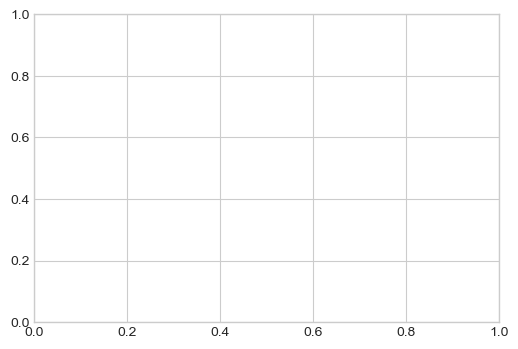

In [4]:
# --- Plotting ---

# Get tech list
y_categories = graph_data.columns.tolist()
y_categories = [y for y in y_categories if y not in ['scenario','year','x_id']]

# Initiate plotting
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(1,1, figsize = (6,4),  sharex = True ) # , layout = 'constrained'

# Create lists to track stacking positions
running_sums_pos = [0]*len(x_scens)
running_sums_neg = [0]*len(x_scens)

# Loop through each tech
for t in range(len(y_categories)):
    yvals = graph_data[y_categories[t]].tolist()
    tech_sums[t] = sum(yvals)
    bottoms = []
    # update stacking positions
    for i in range(len(yvals)):
        if yvals[i] >=0:
            bottoms.append(running_sums_pos[i])
            running_sums_pos[i]+=yvals[i]
        else:
            bottoms.append(running_sums_neg[i])
            running_sums_neg[i]+=yvals[i]
    # Plot bar for the tech for each scenario
    axs.bar(x_scens,yvals, width = 0.5, bottom = bottoms, color = tech_styles_dict[y_categories[t]])

# Customize plot
axs.set_ylabel('TWh')
axs.set_xlabel('Scenario')
plt.xticks(axs.get_xticks(), axs.get_xticklabels(), rotation=90)
#plt.title(label='Absolute Difference in 2050 USA Generation: FC vs. no FC')

# Drop techs with negligible values
for t in range(len(tech_sums)):
    if abs(tech_sums[t]) < 1:
        y_categories.pop(t)

# Customize legend
custom_lines = [Line2D([0], [0], color=tech_styles_dict[x], lw=5) for x in y_categories]
y_categories.reverse()
custom_lines.reverse()
axs.legend(custom_lines, y_categories ,loc='upper left', bbox_to_anchor=(1.050,1.05), fontsize = 9)

Plot generatin build by year. Exploded by scenarios.

In [5]:
# ---- Read Generation Data ----
# Read into dataframe and filter data
report = pd.read_excel('gen_fc.xlsx', sheet_name='All Scenarios')
graph_data = report[(report['year'] >= 2023) &                               # filter years
                    (report['scenario'].isin(['High Electrification', 'High Electrification (FC)']))] 
graph_data = pd.DataFrame(pd.pivot_table(data = graph_data, columns = 'tech', index = ['scenario','year'], values = 'Generation (TWh)', aggfunc = 'sum', fill_value = 0))
graph_data.reset_index(inplace = True, drop = False)
# Get scenarios for x-axis
graph_data['x_id'] = graph_data.scenario+'-'+graph_data.year.astype(str)
x_scens = graph_data.x_id.unique().tolist()

# Get tech clors and put them into a dictionary
tech_styles = pd.read_csv('tech_styles.csv')
tech_styles_dict = tech_styles.set_index(tech_styles.order)['color'].to_dict()

graph_data

tech,scenario,year,Canada,battery_4,battery_8,beccs_mod,biopower,coal,coal-ccs_mod_upgrade,csp,...,hydro,lfill-gas,nuclear,nuclear-smr,o-g-s,pumped-hydro,upv,wind-ofs,wind-ons,x_id
0,High Electrification,2023,60.860649,-1.445953,0.000000,0.000000,4.553995,1034.277117,0.000000,0,...,298.826894,15.128428,778.889143,0.000000,45.866962,-2.242777,287.670832,1.478042,495.731041,High Electrification-2023
1,High Electrification,2026,69.780032,-4.145363,0.000000,0.000000,1.600789,252.750417,0.000000,0,...,290.781886,13.672378,774.667857,0.000000,31.707098,-4.591054,617.383344,30.713152,1398.515415,High Electrification-2026
2,High Electrification,2029,73.883106,-7.727479,0.000000,0.000000,1.300405,112.387641,0.000000,0,...,293.278599,13.254126,758.077063,0.000000,30.505101,-5.743316,792.340643,74.237940,1579.767669,High Electrification-2029
3,High Electrification,2032,70.472117,-21.208027,-0.398203,0.000000,1.751310,58.522372,12.952474,0,...,271.548463,11.420475,717.367564,0.000000,25.966908,-12.876742,1106.226159,124.794509,2249.011030,High Electrification-2032
4,High Electrification,2035,59.129110,-36.395195,-15.600963,102.880008,0.799980,0.000000,9.283269,0,...,251.598375,8.270722,661.485715,0.000000,4.673516,-21.751958,1533.549280,145.274482,3023.190078,High Electrification-2035
5,High Electrification,2038,66.644961,-35.039738,-15.738574,102.966332,0.713351,0.000000,9.465568,0,...,244.130681,9.044660,663.282262,0.000000,4.045708,-20.000140,1785.737765,175.801911,3563.143939,High Electrification-2038
6,High Electrification,2041,67.216721,-38.747775,-21.309790,103.018788,0.655588,0.000000,9.670711,0,...,251.767487,10.218261,678.857923,73.353330,3.014900,-17.993177,1909.931701,253.633377,3922.144919,High Electrification-2041
7,High Electrification,2044,71.974329,-41.759857,-25.160793,103.062368,0.610912,0.000000,3.552012,0,...,259.609809,10.446008,683.152860,76.663268,2.898603,-17.331229,2063.044828,349.373407,4198.470226,High Electrification-2044
8,High Electrification,2047,73.003720,-43.209286,-30.705270,103.069434,0.608284,0.000000,2.851159,0,...,267.008998,10.726618,686.187657,81.190648,2.600663,-17.456770,2203.542585,353.281847,4430.881846,High Electrification-2047
9,High Electrification,2050,73.522768,-45.779491,-34.516304,103.097063,0.588888,0.000000,2.494426,0,...,273.502668,10.600138,663.606368,82.543676,2.312581,-17.618227,2388.725123,357.093350,4601.939905,High Electrification-2050


In [6]:
# ---- Data Organization -----
# Capitalize first letters, lump tech groups, drop storgae & H2 production techs
graph_data['Nuclear'] = graph_data['nuclear'] + graph_data['nuclear-smr']
graph_data['Coal'] = graph_data['coal'] + graph_data['coal-ccs_mod_upgrade']
graph_data['Gas-CC'] = graph_data['gas-cc']
graph_data['Gas-CC CCS'] = graph_data['gas-cc-ccs_mod'] + graph_data['gas-cc-ccs_mod_upgrade']
graph_data['Gas-CT'] = graph_data['gas-ct']
graph_data['Oil/Gas'] = graph_data['o-g-s']
graph_data['Other RE'] = graph_data['hydro'] + graph_data['geothermal'] + graph_data['biopower'] + graph_data['lfill-gas']
graph_data['Fuel Cell'] = graph_data['fuel-cell']
graph_data['H2-CT'] =  graph_data['h2-ct_upgrade'] + graph_data['h2-ct']
graph_data['Onshore Wind'] = graph_data['wind-ons']
graph_data['Offshore Wind'] = graph_data['wind-ofs']
graph_data['Solar'] = graph_data['csp'] + graph_data['upv'] + graph_data['distpv']
#graph_data['Storage'] = graph_data['battery_4'] + graph_data['battery_8'] + graph_data['pumped-hydro'] 

graph_data=graph_data.drop(columns=['nuclear','nuclear-smr', 
                                    'coal','coal-ccs_mod_upgrade',
                                    'gas-cc','gas-cc-ccs_mod', 'gas-cc-ccs_mod_upgrade',
                                    'gas-ct', 'o-g-s', 'beccs_mod',
                                    'lfill-gas',
                                    'fuel-cell',
                                    'h2-ct_upgrade','h2-ct',
                                    'wind-ons', 'wind-ofs',
                                    'csp','upv','distpv',
                                    'hydro','geothermal','biopower',
                                    #'electrolyzer', 'smr', 'smr-ccs',
                                    'battery_4','battery_8','pumped-hydro','Canada'])
graph_data

tech,scenario,year,x_id,Nuclear,Coal,Gas-CC,Gas-CC CCS,Gas-CT,Oil/Gas,Other RE,Fuel Cell,H2-CT,Onshore Wind,Offshore Wind,Solar
0,High Electrification,2023,High Electrification-2023,778.889143,1034.277117,1049.030727,0.000000,74.252225,45.866962,337.020105,0.000000,0.000000,495.731041,1.478042,345.643861
1,High Electrification,2026,High Electrification-2026,774.667857,252.750417,753.946180,0.000000,65.703260,31.707098,345.285927,0.000000,0.000000,1398.515415,30.713152,703.972030
2,High Electrification,2029,High Electrification-2029,758.077063,112.387641,764.084481,0.000000,64.398273,30.505101,350.908331,0.000000,2.354217,1579.767669,74.237940,927.291086
3,High Electrification,2032,High Electrification-2032,717.367564,71.474846,370.113995,49.989259,62.420981,25.966908,331.716504,0.000000,2.948864,2249.011030,124.794509,1291.548732
4,High Electrification,2035,High Electrification-2035,661.485715,9.283269,145.030028,48.418155,24.953544,4.673516,309.850327,0.000000,33.246476,3023.190078,145.274482,1743.890383
5,High Electrification,2038,High Electrification-2038,663.282262,9.465568,143.266725,65.301499,24.013029,4.045708,305.732757,0.000000,78.847333,3563.143939,175.801911,2008.495597
6,High Electrification,2041,High Electrification-2041,752.211253,9.670711,137.595134,96.925853,22.565187,3.014900,322.489598,0.000000,95.581034,3922.144919,253.633377,2144.537243
7,High Electrification,2044,High Electrification-2044,759.816128,3.552012,135.467137,134.314277,17.696666,2.898603,336.604282,0.000000,113.383935,4198.470226,349.373407,2310.750284
8,High Electrification,2047,High Electrification-2047,767.378305,2.851159,124.820163,183.372810,15.516183,2.600663,345.105559,0.000000,129.700444,4430.881846,353.281847,2465.447210
9,High Electrification,2050,High Electrification-2050,746.150044,2.494426,121.742436,193.480911,15.048205,2.312581,353.039802,0.000000,142.679880,4601.939905,357.093350,2667.416729


(0.0, 9663.568183315401)

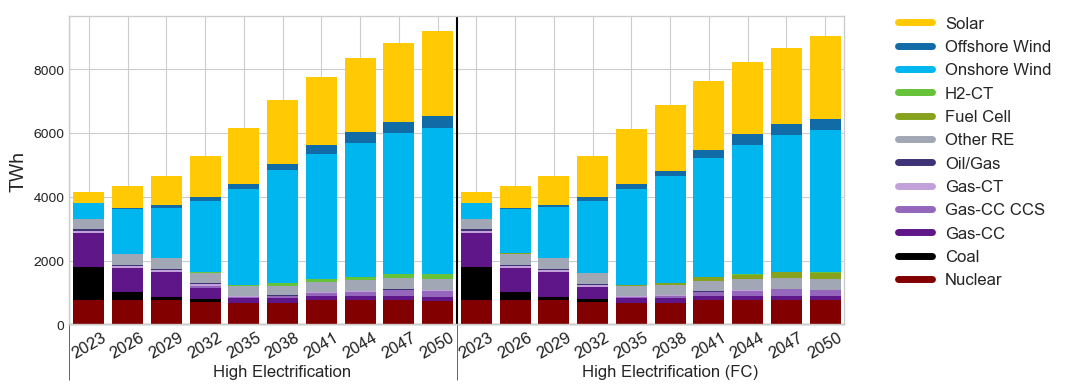

In [7]:
# ---- Plot Exploded by Scenarios ----
y_categories = graph_data.columns.to_list()
y_categories = [y for y in y_categories if y not in ['scenario','year','x_id']]
#y_categories = [y for in y in ['Fuel Cell','H2-CT']]  # Use this line instead of the above when need to single out technologies

# Create lists to track stacking positions
running_sums_pos = [0]*len(x_scens)
running_sums_neg = [0]*len(x_scens)

# Initiate plotting
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(1,1, figsize = (10,4),  sharex = True ) # , layout = 'constrained'

# Lop through techs
for t in range(len(y_categories)):
    yvals = graph_data[y_categories[t]].tolist()
    bottoms = []
    # Update stacking positions
    for i in range(len(yvals)):
        if yvals[i] >=0:
            bottoms.append(running_sums_pos[i])
            running_sums_pos[i]+=yvals[i]
        else:
            bottoms.append(running_sums_neg[i])
            running_sums_neg[i]+=yvals[i]
    # Plot bar chart for the current tech at each scenario
    axs.bar(x_scens,yvals, width = 0.8, bottom = bottoms, color = tech_styles_dict[y_categories[t]])

# Get primary x-axis labels
yrs = [s.split('-')[1] for s in x_scens]
# Get secondary x-axis labels
scen_types = [s.split('-')[0] for s in x_scens]
scen_types = list(set(scen_types))
scen_types = ['\n\n'+s for s in scen_types]
scen_types.reverse()

# Customize plot
plt.xticks(axs.get_xticks(), yrs, rotation=30, fontsize = 12)
axs.set_ylabel('TWh', fontsize = 14)
#axs.set_xlabel('Year', fontsize=12)
#plt.title(label='Absolute USA Generation: FC')

# Get secondary x-axis label positions
yrs_per_s = len(yrs)/len(scen_types)
scen_locs = [yrs_per_s/2 + s*yrs_per_s for s in range(len(scen_types))]

sec = axs.secondary_xaxis(location=0)
sec.set_xticks(scen_locs, labels=scen_types, fontsize=12)
sec.tick_params('x', length=0)

sec2 = axs.secondary_xaxis(location=0)
linevalues = [x-0.5 for x in list(range(0,len(x_scens),math.floor(yrs_per_s)))]
sec2.set_xticks(linevalues, labels=[], fontsize=12)
sec2.tick_params('x', length=40, width=0.5)

# Customize legend
custom_lines = [Line2D([0], [0], color=tech_styles_dict[x], lw=5) for x in y_categories]
custom_lines.reverse()
y_categories.reverse()
axs.legend(custom_lines, y_categories ,loc='upper left', bbox_to_anchor=(1.050,1.05), fontsize = 12)

# Add dividing line between scenarios
ymin = axs.get_ylim()[0]
ymax = axs.get_ylim()[1]
for x in linevalues:
    axs.vlines(x,ymin,ymax*1.1, colors='black')
    axs.set_xlim(-0.5,len(yrs)-0.5)

# Set axes limis
axs.set_xlim(-0.5,len(yrs)-0.5)
axs.set_ylim(ymin,ymax)

Plot the stacked area for generation build by year. Exploded by scenarios.

C:\Users\sshi\AppData\Local\Temp\1\ipykernel_924\58561297.py:82: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


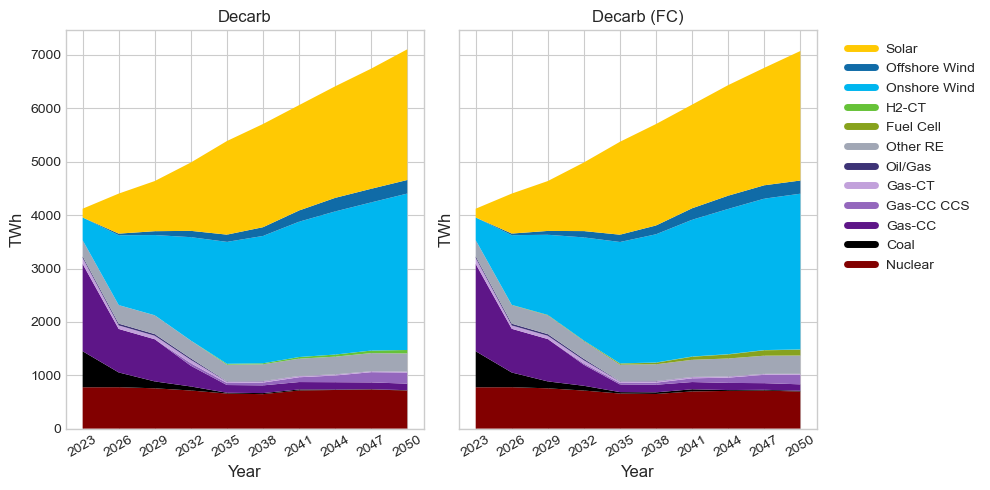

In [33]:
# Read the data
# Read data into a DataFrame
report = pd.read_excel('gen_fc.xlsx', sheet_name='All Scenarios')
# Get tech colors and put them inot a dictionary
tech_styles = pd.read_csv('gen_tech_style.csv')
tech_styles_dict = tech_styles.set_index(tech_styles.order)['color'].to_dict()

# Function to prepare and plot stacked area plot for a given scenario
def plot_stacked_area(ax, graph_data, tech_styles_dict, y_categories):
    x = np.arange(len(graph_data))
    data_values = [graph_data[tech].values for tech in y_categories]
    data_values = np.array(data_values)

    ax.stackplot(x, data_values, labels=y_categories, colors=[tech_styles_dict[tech] for tech in y_categories])
    ax.set_ylabel('TWh', fontsize=12)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(graph_data.index, rotation=30, fontsize=10)

# Filter scenarios and prepare the data
scenarios = ['Decarb', 'Decarb (FC)']  # Add other scenarios if needed
num_scenarios = len(scenarios)

# Create the figure and axes for side-by-side plots
fig, axs = plt.subplots(1, num_scenarios, figsize=(10,5), sharey=True, constrained_layout=True)

# Initialize lists to store legend handles and labels
all_handles = []
all_labels = []

# Loop through scenarios and plot each one
for idx, scenario in enumerate(scenarios):
    # Filter and pivot the data for the current scenario
    graph_data = report[(report['year'] >= 2023) & (report['scenario'] == scenario)]
    graph_data = pd.DataFrame(pd.pivot_table(data=graph_data, columns='tech', index='year', values='Generation (TWh)', aggfunc='sum', fill_value=0))
    
    # ---- Data Organization -----
    graph_data['Nuclear'] = graph_data['nuclear'] + graph_data['nuclear-smr']
    graph_data['Coal'] = graph_data['coal'] + graph_data['coal-ccs_mod_upgrade']
    graph_data['Gas-CC'] = graph_data['gas-cc']
    graph_data['Gas-CC CCS'] = graph_data['gas-cc-ccs_mod'] + graph_data['gas-cc-ccs_mod_upgrade']
    graph_data['Gas-CT'] = graph_data['gas-ct']
    graph_data['Oil/Gas'] = graph_data['o-g-s']
    graph_data['Other RE'] = graph_data['hydro'] + graph_data['geothermal'] + graph_data['biopower'] + graph_data['lfill-gas']
    graph_data['Fuel Cell'] = graph_data['fuel-cell']
    graph_data['H2-CT'] =  graph_data['h2-ct_upgrade'] + graph_data['h2-ct']
    graph_data['Onshore Wind'] = graph_data['wind-ons']
    graph_data['Offshore Wind'] = graph_data['wind-ofs']
    graph_data['Solar'] = graph_data['csp'] + graph_data['upv'] + graph_data['distpv']
    #graph_data['Storage'] = graph_data['battery_4'] + graph_data['battery_8'] + graph_data['pumped-hydro'] 

    graph_data=graph_data.drop(columns=['nuclear','nuclear-smr', 
                                        'coal','coal-ccs_mod_upgrade',
                                        'gas-cc','gas-cc-ccs_mod', 'gas-cc-ccs_mod_upgrade',
                                        'gas-ct', 'o-g-s', 'beccs_mod',
                                        'lfill-gas',
                                        'fuel-cell',
                                        'h2-ct_upgrade','h2-ct',
                                        'wind-ons', 'wind-ofs',
                                        'csp','upv','distpv',
                                        'hydro','geothermal','biopower',
                                        #'electrolyzer', 'smr', 'smr-ccs',
                                        'battery_4','battery_8','pumped-hydro','Canada'])

    # Filter out technologies with negligible sum
    y_categories = graph_data.columns.tolist()
    for tech in y_categories:
        if sum(graph_data[tech]) < 0.1:
            y_categories.remove(tech)
    
    # Plot the stacked area plot for the current scenario
    plot_stacked_area(axs[idx], graph_data, tech_styles_dict, y_categories)
    axs[idx].set_title(f'{scenario}')

# Add the legend to the last subplot (or you can choose any subplot)
#axs[1].legend(unique_handles, unique_labels, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
custom_lines = [Line2D([0], [0], color=tech_styles_dict[tech], lw=5) for tech in y_categories]
custom_lines.reverse()
y_categories.reverse()
axs[1].legend(custom_lines, y_categories, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10, frameon=False)

plt.tight_layout()

Plot Absolute Generation Build out by year

In [60]:
# ---- Read Generation Data ----
# Read data into a data frame and filter data
report = pd.read_excel('gen_fc.xlsx', sheet_name='All Scenarios')
graph_data = report[(report['year'] >= 2023) &                               # filter years
                    (report['scenario'].isin(['BAU']))]                     # filter scenarios
graph_data = pd.DataFrame(pd.pivot_table(data = graph_data, columns = 'tech', index = 'year', values = 'Generation (TWh)', aggfunc = 'sum', fill_value = 0))

# get tech colors adn putthem into a dictionary
tech_styles = pd.read_csv('gen_tech_style.csv')
tech_styles_dict = tech_styles.set_index(tech_styles.order)['color'].to_dict()

graph_data

tech,Canada,battery_4,battery_8,beccs_mod,biopower,coal,coal-ccs_mod_upgrade,csp,distpv,fuel-cell,...,h2-ct_upgrade,hydro,lfill-gas,nuclear,nuclear-smr,o-g-s,pumped-hydro,upv,wind-ofs,wind-ons
year,,,,,,,,,,,,,,,,,,,,,
2023,60.860808,-1.454060,0.000000,0.0,4.794004,1011.350675,0.0,0.0,59.518286,0.0,...,0.000000,298.829193,15.135145,778.486646,0.000000,46.791154,-2.941090,293.708781,1.641680,494.285306
2026,70.213035,-4.358046,0.000000,0.0,1.531435,272.309786,0.0,0.0,88.794798,0.0,...,0.000000,292.685940,13.904107,776.935986,0.000000,32.558565,-4.305978,658.677244,30.745135,1304.945307
2029,73.815805,-7.646710,-0.010997,0.0,1.325647,124.650786,0.0,0.0,138.250556,0.0,...,0.000000,293.802216,13.290809,756.614564,0.000000,30.732584,-6.263548,780.792337,72.057570,1490.135461
2032,75.277984,-13.227439,-0.090699,0.0,1.055002,125.963891,0.0,0.0,189.636608,0.0,...,0.000000,283.340511,12.798673,739.908714,0.000000,26.446164,-9.087541,936.279416,127.886310,1707.112661
2035,73.356275,-17.275464,-0.081204,0.0,0.844027,167.784651,0.0,0.0,214.979259,0.0,...,0.000000,277.457637,12.109938,601.232378,0.000000,21.765136,-12.409399,1139.541144,163.544439,1980.176155
2038,72.995443,-21.749930,-0.157402,0.0,0.712626,142.805046,0.0,0.0,227.419530,0.0,...,0.000000,272.651792,11.565833,592.407497,0.000000,20.645378,-14.357408,1348.747483,167.267325,2193.014872
2041,70.732714,-29.890360,-4.568525,0.0,0.887614,135.218856,0.0,0.0,239.328013,0.0,...,0.000000,271.703573,10.559978,585.897603,0.000000,15.557469,-19.670528,1584.725947,174.295568,2394.025819
2044,71.036636,-37.112644,-12.931847,0.0,0.985583,100.426707,0.0,0.0,252.517732,0.0,...,0.000000,270.096455,10.246040,582.344244,0.000000,13.948563,-20.725501,1844.524996,176.890779,2494.236302
2047,72.583498,-37.544404,-13.925204,0.0,0.998969,91.759417,0.0,0.0,266.836835,0.0,...,1.678559,275.798656,11.149642,592.006222,0.000000,10.591786,-18.701821,1862.389404,204.417078,2564.608206


In [61]:
# ---- Data Organization -----
graph_data['Nuclear'] = graph_data['nuclear'] + graph_data['nuclear-smr']
graph_data['Coal'] = graph_data['coal'] + graph_data['coal-ccs_mod_upgrade']
graph_data['Gas-CC'] = graph_data['gas-cc']
graph_data['Gas-CC CCS'] = graph_data['gas-cc-ccs_mod'] +graph_data['gas-cc-ccs_mod_upgrade']
graph_data['Gas-CT'] = graph_data['gas-ct']
graph_data['Oil/Gas'] = graph_data['o-g-s']
graph_data['Other RE'] = graph_data['hydro'] + graph_data['geothermal'] + graph_data['biopower']+ graph_data['lfill-gas']
graph_data['Fuel Cell'] = graph_data['fuel-cell']
graph_data['H2-CT'] = graph_data['h2-ct'] + graph_data['h2-ct_upgrade']
graph_data['Onshore Wind'] = graph_data['wind-ons']
graph_data['Offshore Wind'] = graph_data['wind-ofs']
graph_data['Solar'] = graph_data['csp'] + graph_data['upv'] + graph_data['distpv']

graph_data=graph_data.drop(columns=['nuclear','nuclear-smr', 
                                    'coal','coal-ccs_mod_upgrade',
                                    'gas-cc','gas-cc-ccs_mod','gas-cc-ccs_mod_upgrade',
                                    'gas-ct', 'o-g-s', 'beccs_mod',
                                    'hydro',
                                    'lfill-gas','geothermal','biopower',
                                    'fuel-cell',
                                    'h2-ct','h2-ct_upgrade',
                                    'wind-ons', 'wind-ofs',
                                    'csp','upv','distpv',
                                    'battery_4','battery_8','pumped-hydro','Canada'])
graph_data

tech,Nuclear,Coal,Gas-CC,Gas-CC CCS,Gas-CT,Oil/Gas,Other RE,Fuel Cell,H2-CT,Onshore Wind,Offshore Wind,Solar
year,,,,,,,,,,,,
2023,778.486646,1011.350675,1106.279533,0.000000,74.243098,46.791154,337.269103,0.0,0.000000,494.285306,1.641680,353.227067
2026,776.935986,272.309786,823.505508,0.000000,66.908693,32.558565,347.461043,0.0,0.000000,1304.945307,30.745135,747.472042
2029,756.614564,124.650786,822.621967,0.000000,67.834100,30.732584,351.440988,0.0,0.000000,1490.135461,72.057570,919.042893
2032,739.908714,125.963891,694.076259,0.000000,68.388682,26.446164,341.649825,0.0,0.327260,1707.112661,127.886310,1125.916024
2035,601.232378,167.784651,623.910999,5.368895,67.378993,21.765136,339.977365,0.0,0.327260,1980.176155,163.544439,1354.520404
2038,592.407497,142.805046,548.887423,23.145646,67.984651,20.645378,336.363638,0.0,0.327260,2193.014872,167.267325,1576.167013
2041,585.897603,135.218856,465.133083,22.757290,70.417467,15.557469,337.093259,0.0,5.496197,2394.025819,174.295568,1824.053960
2044,582.344244,100.426707,464.973316,22.078834,76.261230,13.948563,337.417635,0.0,5.536405,2494.236302,176.890779,2097.042729
2047,592.006222,91.759417,587.730095,34.398012,99.508166,10.591786,343.872559,0.0,8.857826,2564.608206,204.417078,2129.226240


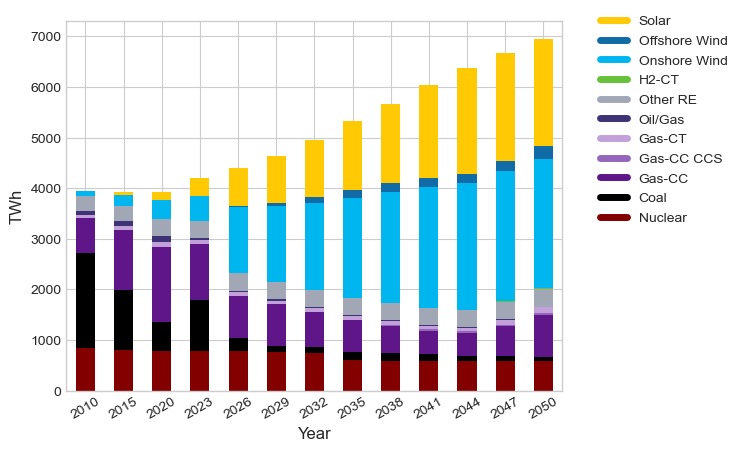

In [47]:
# ---- Plotting ----
# Get tech list and drop negligible values
y_categories = graph_data.columns.tolist()
for tech in y_categories:
    if sum(graph_data[tech]) < 0.1:
        y_categories.remove(tech)
y_categories.reverse()

# Plot stacked bars
plt.style.use('seaborn-v0_8-whitegrid')
fig = graph_data.plot.bar(stacked=True, color = tech_styles_dict)

# customize plot
fig.set_ylabel('TWh', fontsize = 12)
fig.set_xlabel('Year', fontsize = 12)
plt.xticks(rotation=30)

# Customize legend
custom_lines = [Line2D([0], [0], color=tech_styles_dict[x], lw=5) for x in y_categories]
fig.legend(custom_lines, y_categories ,loc='upper left', bbox_to_anchor=(1.050,1.05), fontsize = 10)

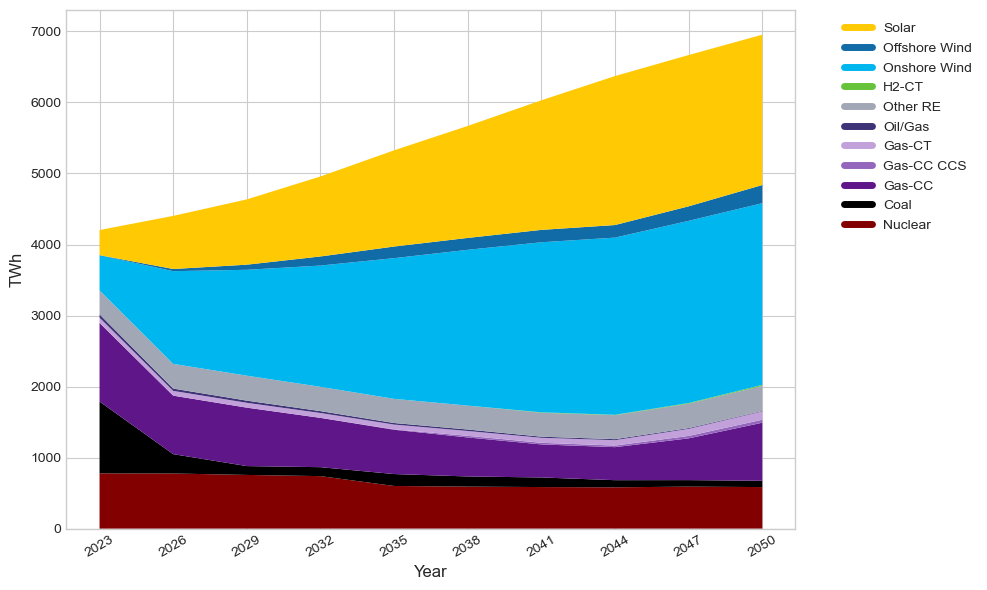

In [65]:
# Filter out technologies with negligible sum
y_categories = graph_data.columns.tolist()
for tech in y_categories:
    if sum(graph_data[tech]) < 0.1:
        y_categories.remove(tech)


# Prepare data for stacked area plot
x = np.arange(len(graph_data))
data_values = [graph_data[tech].values for tech in y_categories]
data_values = np.array(data_values)

# Plot stacked area plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
ax.stackplot(x, data_values, labels=y_categories, colors=[tech_styles_dict[tech] for tech in y_categories])

# Customize plot
ax.set_ylabel('TWh', fontsize=12)
ax.set_xlabel('Year', fontsize=12)

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(graph_data.index, rotation=30, fontsize=10)

# Create custom legend
custom_lines = [Line2D([0], [0], color=tech_styles_dict[tech], lw=5) for tech in y_categories]
custom_lines.reverse()
y_categories.reverse()
ax.legend(custom_lines, y_categories, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)

plt.tight_layout()